# install and import packages

In [2]:
!pip install numpy pyDOE2 scikit-learn lime anchor-exp tabulate river pytest

Defaulting to user installation because normal site-packages is not writeable


# Experiments 

## Functions

In [3]:
from tabulate import tabulate
import time

def get_trg_sample(index):
    print('Index: ', index)
    raw_dataset = utils.load_dataset(
        dataset_name, balance=True, dataset_folder=dataset_folder, discretize=False)
    # raw_dataset2 = utils.load_csv_dataset(
    #     os.path.join(dataset_folder, 'recidivism/Data_1980.csv'), 16,
    #     discretize=False,
    #     features_to_use=None, balance=True)
    trg = dataset.test[index]
    
    trg_data = list(zip(raw_dataset.feature_names, raw_dataset.test[index]))
    # trg_data2 = list(zip(raw_dataset2.feature_names, raw_dataset2.test[index]))
    
    print('Prediction:', raw_dataset.class_names[rf.predict(trg.reshape(1, -1))[0]])
    print('True:      ', raw_dataset.class_names[dataset.labels_test[index]])
    print(tabulate(trg_data))
    # print(tabulate(trg_data2))
    return trg

In [39]:
import explanation
import lime_tabular

def lime_original(trg):
    lime_explainer = lime_tabular.LimeTabularExplainer(
        dataset.train,
        feature_names=dataset.feature_names,
        class_names=dataset.class_names,
        discretize_continuous=False)
    lime_exp = lime_explainer.explain_instance(
        trg, rf.predict_proba, num_features=5, top_labels=1)
    # lime_exp.show_in_notebook(show_table=True, show_all=True)
    weights = [0] * len(dataset.feature_names)
    for t in lime_exp.local_exp[1]:
        weights[t[0]] = t[1]
    plot_weights(weights, dataset.feature_names)

In [5]:
from anchor import anchor_tabular

def anchor_original(trg, threshold=0.85):
    anchor_explainer = anchor_tabular.AnchorTabularExplainer(
        dataset.class_names,
        dataset.feature_names,
        dataset.train,
        dataset.categorical_names)
    anchor_exp = anchor_explainer.explain_instance(
        trg, rf.predict, threshold)

    print('Threshold:  %.2f' % threshold)
    # print('Prediction:', anchor_explainer.class_names[rf.predict(trg.reshape(1, -1))[0]])
    print('Anchor:     %s' % (' AND '.join(anchor_exp.names())))
    print('Precision:  %.2f' % anchor_exp.precision())
    print('Coverage:   %.2f' % anchor_exp.coverage())

In [41]:
import my_anchor_base
import my_anchor_tabular

# display
import matplotlib.pyplot as plt
    
import importlib
importlib.reload(my_anchor_base)
importlib.reload(my_anchor_tabular)

def new_lime(trg, threshold=0.90):
    anchor_explainer = my_anchor_tabular.AnchorTabularExplainer(
        dataset.class_names,
        dataset.feature_names,
        dataset.train,
        dataset.categorical_names)
    anchor_exp, surrogate_model = anchor_explainer.explain_instance(trg, rf.predict, threshold=threshold)
    plot_weights(
        list(surrogate_model['LogisticRegression'].weights.values()),
        dataset.feature_names,
        ' AND '.join(anchor_exp.names()),
        anchor_exp.precision(),
        anchor_exp.coverage()
    )
    

In [7]:
def plot_weights(weights, feature_names, anchor=None, precision=None, coverage=None):
    features = feature_names
    values = weights
    abs_values = [abs(x) for x in values]
    _, sorted_features, sorted_values = zip(*sorted(zip(abs_values, features, values), reverse=False)[-5:])
    plt.figure()
    color = ['#32a852' if sorted_values[i] > 0 else '#cf4529' for i in range(len(sorted_values))]
    plt.barh(sorted_features, sorted_values, color=color)
    if anchor != None:
        plt.title('%s\nwith Precision %.2f and Coverage %.2f' % (anchor, precision, coverage))
    for i in range(len(sorted_features)):
        plt.text(sorted_values[i], sorted_features[i], round(sorted_values[i], 5))
    plt.show

## Generating Explanations

In [8]:
import utils
import os

dataset_folder = 'datasets/'
# dataset_name = 'adult'
# dataset_name = 'diabetes'
# dataset_name = 'default'
dataset_name = 'recidivism'
# dataset_name = 'lending'

dataset = utils.load_dataset(
    dataset_name, balance=True, dataset_folder=dataset_folder, discretize=True)

In [9]:
import sklearn.ensemble

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=5)

rf.fit(dataset.train, dataset.labels_train)
print('Train', sklearn.metrics.accuracy_score(
    dataset.labels_train, rf.predict(dataset.train)))
print('Test', sklearn.metrics.accuracy_score(
    dataset.labels_test, rf.predict(dataset.test)))

Train 0.935226264418811
Test 0.7531914893617021


In [37]:
import numpy as np

importlib.reload(my_anchor_base)
importlib.reload(my_anchor_tabular)

i = np.random.randint(0, dataset.test.shape[0])

# adult
# 730, 956, 1196, 1522
# i = 1443 # --- Capital Gain = 2

# recidivism 
# 444, 542
# i = 80 ???
i = 444
# i = 542
trg = get_trg_sample(i)

Index:  444
Prediction: b'1'
True:       b'1'
----------------------  --
Race                     1
Alcohol                  0
Junky                    0
Supervised Release       1
Married                  0
Felony                   1
WorkRelease              1
Crime against Property   1
Crime against Person     0
Gender                   1
Priors                   1
YearsSchool             10
PrisonViolations         1
Age                     22
MonthsServed            33
----------------------  --
-------  ---
WHITE      1
ALCHY      0
JUNKY      0
SUPER      1
MARRIED    0
FELON      1
WORKREL    1
PROPTY     1
PERSON     0
MALE       1
PRIORS     0
SCHOOL    10
RULE       5
AGE      271
TSERVD    33
FOLLOW     3
TIME      45
FILE       2
-------  ---


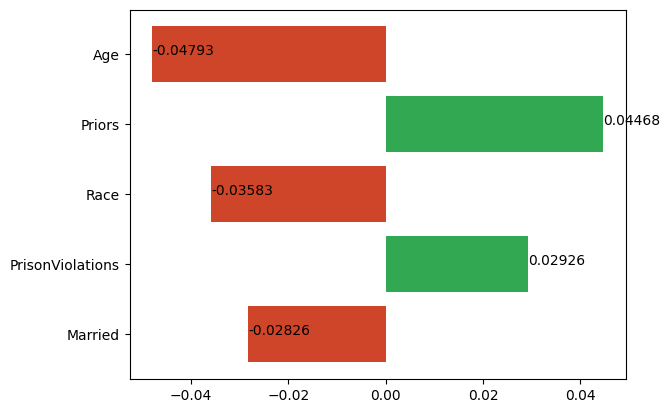

In [40]:
lime_original(trg)
img_file = 'img/%s/%05d-LIME.png' % (dataset_name, i)
plt.savefig(img_file, bbox_inches='tight')

Threshold:  0.70
Anchor:     Priors = 1 AND Age > 33.00
Precision:  0.74
Coverage:   0.06

Threshold:  0.75
Anchor:     Priors = 1 AND MonthsServed <= 4.00 AND Married = 1
Precision:  0.81
Coverage:   0.03

Threshold:  0.80
Anchor:     Age > 33.00 AND Priors = 1 AND Married = 1
Precision:  0.86
Coverage:   0.03



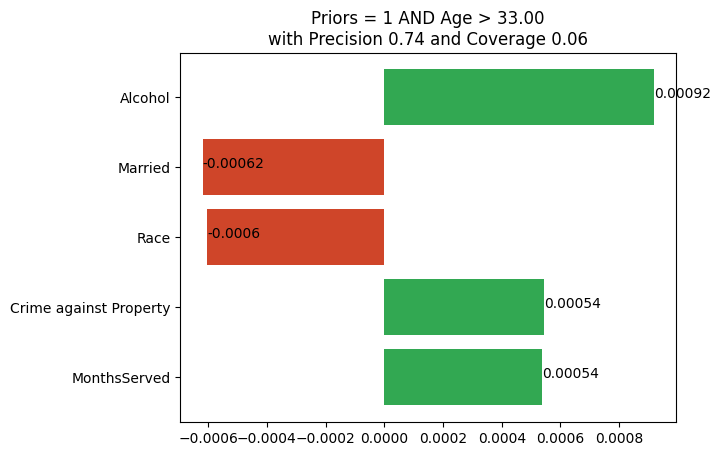

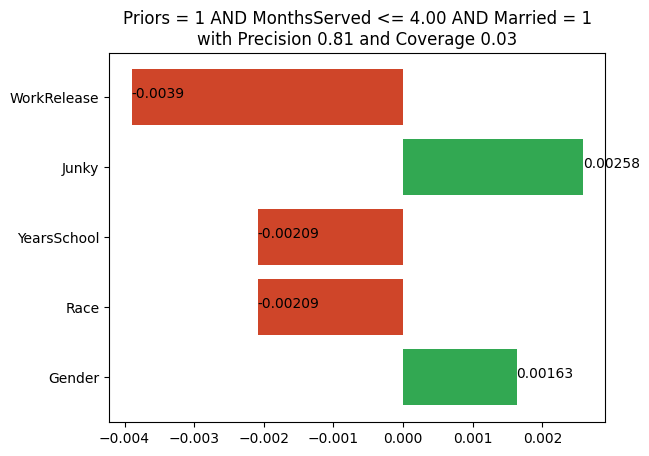

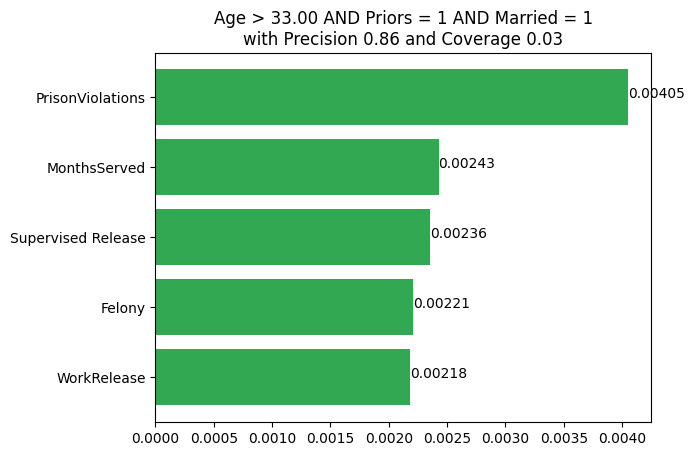

In [12]:
for t in [0.70, 0.75, 0.80]:
    new_lime(trg, threshold=t)
    img_file = 'img/%s/%05d-%03d.png' % (dataset_name, i, t * 100)
    plt.savefig(img_file, bbox_inches='tight')

Threshold:  0.75
Anchor:     Married = 1 AND Age > 33.00 AND Priors = 1
Precision:  0.86
Coverage:   0.02



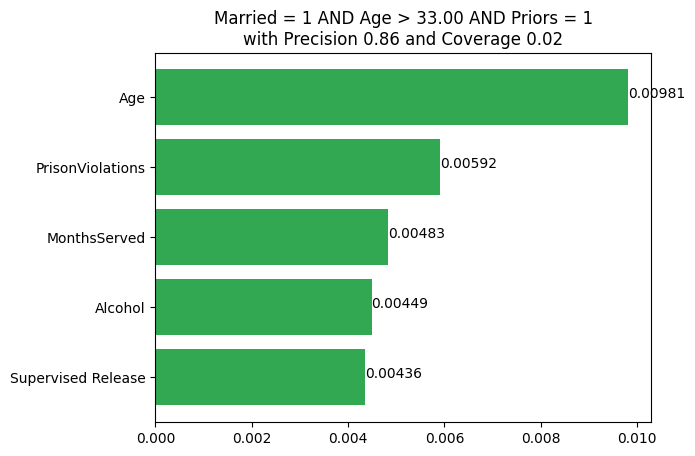

In [13]:
new_lime(trg, threshold=0.75)

Threshold:  0.80
Anchor:     Married = 1 AND Priors = 1 AND Age > 33.00
Precision:  0.86
Coverage:   0.03



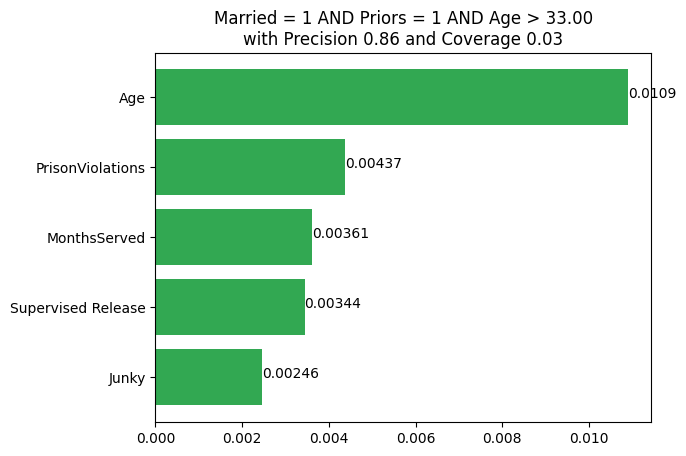

In [14]:
new_lime(trg, threshold=0.80)

In [15]:
anchor_original(trg, threshold=0.80)

Threshold:  0.80
Anchor:     Married = 1 AND Age > 33.00 AND MonthsServed <= 4.00
Precision:  0.88
Coverage:   0.03
